In [1]:
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
img = io.imread("D:/Library/Datasets/SYNTHIA-SF/SEQ2/RGBRight/0000500.png")
depth = io.imread("D:/Library/Datasets/SYNTHIA-SF/SEQ2/DepthRight/0000500.png")
depth = np.array(
                (depth[ :, :, 0] + depth[ :, :, 1] * 256.0 +
                 depth[ :, :, 2] * 256 * 256.0) / ((256 * 256 * 256) - 1),
                dtype=np.float32) * 1000

In [3]:
img = np.array(img[:,:,0:3], np.float32) / 256.0

In [4]:
s_height = 512
s_width = 512
i_height = 1080
i_width = 1920

In [5]:
row_num = int(np.ceil(i_height/s_height))
column_num = int(np.ceil(i_width/s_width))

In [6]:
column_step = int( np.floor((i_height - s_height)/row_num) )
row_step = int( np.floor((i_width - s_width)/column_num) ) 

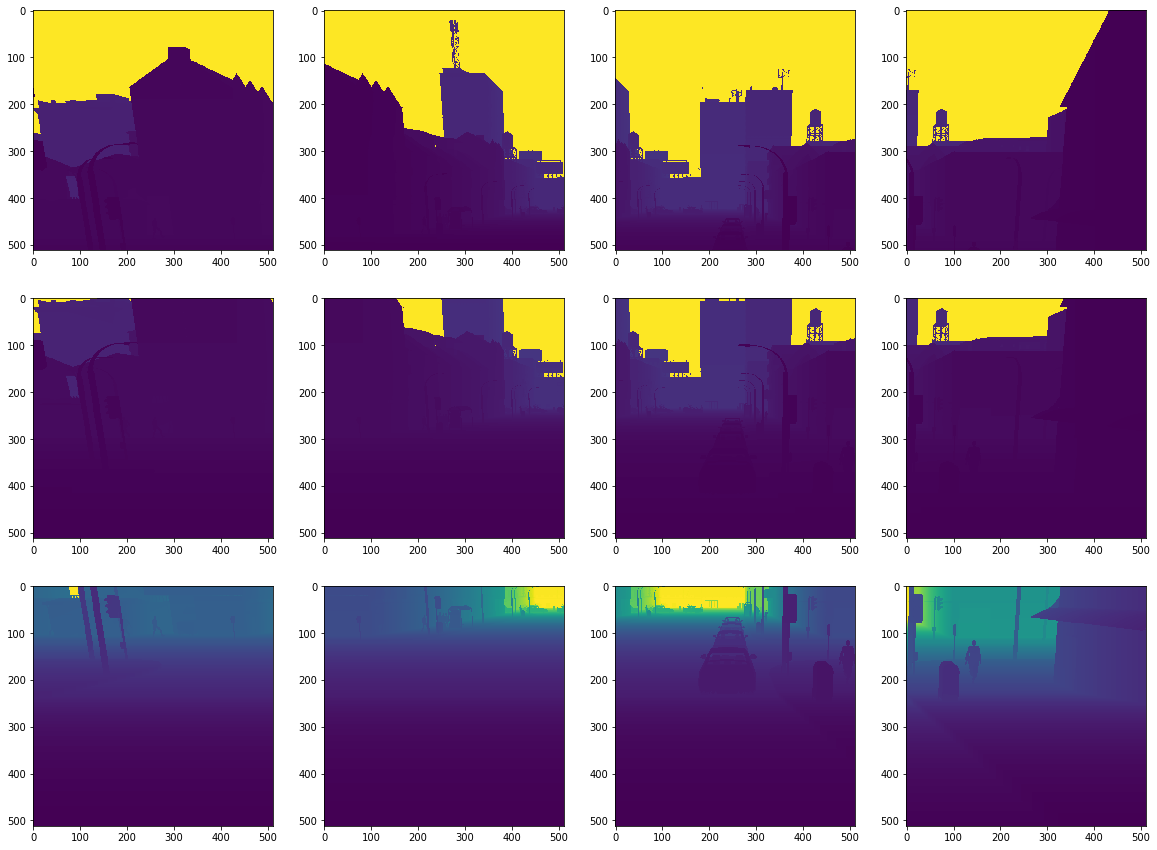

In [7]:
plt.figure(figsize=(5*column_num, 5*row_num))
# x = []
for row in range(row_num):
    for column in range(column_num):
        plt.subplot(row_num, column_num, row*column_num + column + 1)
        plt.imshow(depth[column_step*row : s_height + column_step*row, 
                       row_step*column : s_width + row_step*column])
#         x.append(img[column_step*row : s_height + column_step*row, 
#                        row_step*column : s_width + row_step*column])

In [8]:
s_height = 512
s_width = 512
i_height = img.shape[0]
i_width = img.shape[1]

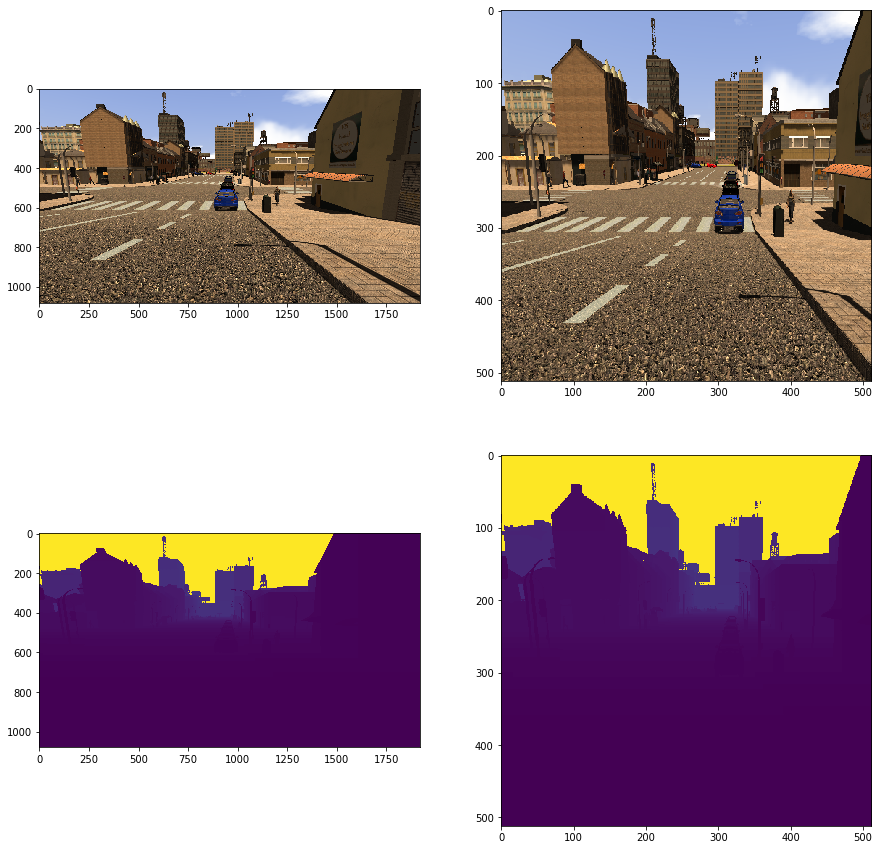

In [9]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.imshow( img)
plt.subplot(2,2,2)
plt.imshow( img[0:512*2:2, 0:512*3:3] )

plt.subplot(2,2,3)
plt.imshow( depth)
plt.subplot(2,2,4)
plt.imshow( depth[0:512*2:2, 0:512*3:3] )

In [12]:
# img_vis = img[0:512*2:2, 0:512*3:3]
# depth_vis = depth[0:512*2:2, 0:512*3:3]

img_vis = img#[0:512*2:2, 0:512*3]
depth_vis = depth#[0:512*2:2, 0:512*3]

In [11]:
dims = (int(img.shape[1]/1), int(img.shape[0]/1))
img_vis = cv2.resize(img, dims,  interpolation = cv2.INTER_NEAREST)
depth_vis = cv2.resize(depth, dims, interpolation = cv2.INTER_NEAREST)

In [51]:
feature_list =[np.expand_dims(img_vis, 0) ]
label_list=[np.expand_dims(np.expand_dims(depth_vis, 0), -1)]

In [52]:
feature_list[0].shape

(1, 270, 480, 3)

In [16]:
COMMON_SETTING = {
    'table_address' : "./utils/labels.csv",
    'batch_size' : 1, 
    'output_shape' : (1080, 1920),
    'data_type' : 'float32',
    'feature_types' : ['image' ],
    'label_types' : ['depth'], #'semantic_depth'
    'class_ids' : 'all'#data_importer.COMMON_LABEL_IDS.copy()#[55,]#
}

In [17]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from utils import visualizer as vis

options=['Simple plot', 'RGB point cloud', 'Segmented point cloud']

def f(x, y):
    class_name = dsg_train.label_table.loc[dsg_train.class_ids[y-1]][0]
    vis.draw_samples(feature_list, label_list, x-1,
                     feature_types=COMMON_SETTING['feature_types'], 
                     label_types=COMMON_SETTING['label_types'], 
                     class_name = class_name,
                     class_index=y-1)
    
def f2(x):
    vis.draw_point_cloud(label_list[0][x-1], feature_list[0][x-1])
    
def view_type_selector(y):
    if y == options[0]:
        interact(f, 
                 x=widgets.IntSlider(description="Sample Num", min=1, max=dsg_train.batch_size, continuous_update=False), 
                 y=widgets.IntSlider(description="Sample layer", min=1, max=len(dsg_train.class_ids), continuous_update=False))
    if y == options[1]:
        interact_manual(f2,
                        x=widgets.IntSlider(description="Sample Num", min=1, max=dsg_train.batch_size, continuous_update=False))
    else:
        print(y)
        
x=interact_manual(view_type_selector, y=widgets.Dropdown(description="View type:", options=options))

interactive(children=(Dropdown(description='View type:', options=('Simple plot', 'RGB point cloud', 'Segmented…

In [15]:
import open3d as o3d

In [16]:
a = o3d.geometry.Image(img_vis)
b = o3d.geometry.Image(depth_vis)
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(a, b)

In [64]:
img_vis.shape

(1080, 1920, 3)

In [73]:
x = o3d.camera.PinholeCameraIntrinsic(width=img_vis.shape[1],
                                      height=img_vis.shape[0],
                                      fx=847.630211643,
                                      fy= 847.630211643,
                                      cx=img_vis.shape[1]/2-.5,
                                      cy=img_vis.shape[0]/2-.5)
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(  #pylint: disable=no-member
        rgbd_image,x)

rgb_vector = np.reshape(img_vis, [-1, 3])
pcd.colors = o3d.utility.Vector3dVector(rgb_vector)  #pylint: disable=no-member
o3d.visualization.draw_geometries([pcd])  #pylint: disable=no-member

In [74]:
o3d.io.write_point_cloud("full.ply", pcd)

True

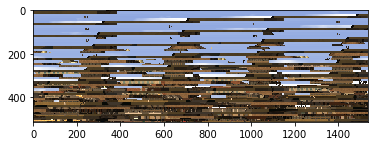

In [21]:
plt.imshow(np.asarray(a))

In [22]:
np.asarray(a).shape

(512, 1536, 3)

In [23]:
img_vis.shape

(512, 1536, 3)

In [24]:
import skimage.transform as tr

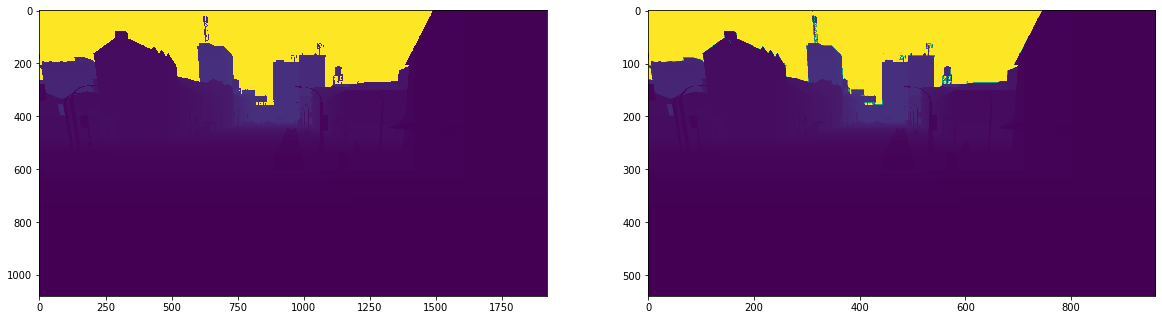

In [26]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(depth)
plt.subplot(1,2,2)
plt.imshow(tr.pyramid_reduce(depth, sigma=0))